In [1]:
import math
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [2]:
class RBM(object):
    def __init__(self, input_size, output_size, learning_rate=1.0):
        #Hiper Parametros
        self.input_size = input_size
        self.output_size = output_size
        #Numero de iterações no treinamento
        self.epochs = 5
        #Learning rate do gradient descent
        self.learning_rate = learning_rate
        #Quantidade de dados usados em cada sub-iteração
        self.batch_size = 100
        
        #Inicializa os pesos e as bias como matrizes
        #Inicializa os pesos
        self.w = np.random.uniform(size=[input_size, output_size])
        #Hidden Bias
        self.hb = np.random.uniform(size=[output_size])
        #Visible Bias
        self.vb = np.random.uniform(size=[input_size])
    
    def rbm_forward(self, X):
        #Multiplica o input X pelos pesos w e soma com a hidden bias hb e em seguida passa o resultado pela sigmoide
        out = tf.math.sigmoid(np.matmul(X, self.w) + self.hb)
        out = tf.nn.relu(tf.sign(out - np.random.uniform(size=tf.shape(out))))
        
        return out
    
    def rbm_back(self, _X):
        out = tf.math.sigmoid(np.matmul(_X, tf.transpose(self.w)) + self.vb)
        out = tf.nn.relu(tf.sign(out - np.random.uniform(size=tf.shape(out))))
        out_1 = tf.math.sigmoid(np.matmul(out, self.w) + self.hb)
        
        return out, out_1
    
    def train(self, X):
        #v0 = X
        #h0 = pos_pass
        #v1 = neg_pass
        #h1 = neg_pass_sig
        pos_pass = self.rbm_forward(X)
        neg_pass, neg_pass_sig = self.rbm_back(pos_pass)
        w_pos_grad = np.matmul(tf.transpose(X), pos_pass)
        w_neg_grad = np.matmul(tf.transpose(neg_pass), neg_pass_sig)
        CD = (w_pos_grad - w_neg_grad) / tf.shape(X)[1]
        self.w = self.w + self.learning_rate * CD
        self.vb = self.vb + self.learning_rate * tf.reduce_mean(X - neg_pass, 0)
        self.hb = self.hb + self.learning_rate * tf.reduce_mean(pos_pass - neg_pass_sig, 0)
        
        #retorna o erro
        return tf.reduce_mean(tf.square(X - neg_pass)).numpy()
    

In [3]:
from tensorflow.keras.datasets import mnist
(train_data, train_label), (test_data, test_label) = mnist.load_data()

In [4]:
RBM_hidden_sizes = [500, 200, 50]
input_X = train_data[0]
#Lista que ira armazenar as RBM
rbm_list = []
#O input_size é o numro de elementos no training set
input_size = np.power(input_X.shape[1], 2)

#Para cada RBM que será gerada
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ', i, ' ', input_size, '->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   784 -> 500
RBM:  1   500 -> 200
RBM:  2   200 -> 50


In [5]:
input_X = np.reshape(input_X, [1, np.prod(np.shape(input_X))])
print(np.shape(input_X))

(1, 784)


In [6]:
for rbm in rbm_list:
    print('New RBM')
    #Treinsa a RBM
    rbm.train(input_X)
    #Passa a saida da camada anterior como entrada da proxima camada
    input_X = rbm.rbm_forward(input_X)

New RBM
New RBM
New RBM


In [7]:
class DBN(object):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=1.0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.rbm_list = []
        
        #Cria a rede 
        for i, size in enumerate(hidden_size):
            print('RBM: ', i, ' ', input_size, '->', size)
            self.rbm_list.append(RBM(input_size, size))
            input_size = size
        self.rbm_list.append(RBM(input_size, output_size))
        print('RBM: ', len(hidden_size), ' ', input_size, '->', output_size)
        
    #--------------------------------------------------------------------------
    def dbn_forward(self, X):
        for rbm in self.rbm_list:
            out = rbm.rbm_forward(X)
            X = out
        
        return X
    
    #--------------------------------------------------------------------------
    def dbn_back(self, Y):
        for rbm in reversed(self.rbm_list):
            out, out_ = rbm.rbm_back(Y)
            Y = out
        
        return Y
    
    #--------------------------------------------------------------------------
    def dbn_train(self, X):
        error = []
        for rbm in self.rbm_list:
            #Treinsa a RBM
            error.append(rbm.train(X))
            #Passa a saida da camada anterior como entrada da proxima camada
            X = rbm.rbm_forward(X)
            
        return error
            

In [8]:
DBN = DBN(784, [], 200)

RBM:  0   784 -> 200


In [9]:
input_X = train_data
print(np.shape(input_X))
epochs = 1000
batch_size = 300
verbose = 10

(60000, 28, 28)


In [10]:
for epoch in range(epochs):
    index = np.random.randint(low=0, high=len(input_X), size=batch_size)
    batch = input_X[index]
    for i, X in enumerate(batch):
        X = np.reshape(X, [1, np.prod(np.shape(X))])
        error = DBN.dbn_train(X)
        print("\r                                                                  ", end="")
        print('\repoch: ', epoch, ' batch: ', i, '/', batch_size, end ="")
    
    if((epoch + 1)%verbose == 0):
        print("                                                                      ")
        print("\repoch: ", epoch+1, '/', epochs, '\n\terro: ', error)
        print("                                                                       ")

epoch:  9  batch:  299 / 300                                                                      00
epoch:  10 / 1000 
	erro:  [10520.335459183674]
                                                                       
epoch:  19  batch:  299 / 300                                                                      
epoch:  20 / 1000 
	erro:  [6362.600765306122]
                                                                       
epoch:  29  batch:  299 / 300                                                                      
epoch:  30 / 1000 
	erro:  [12789.526785714286]
                                                                       
epoch:  39  batch:  299 / 300                                                                      
epoch:  40 / 1000 
	erro:  [4653.9579081632655]
                                                                       
epoch:  49  batch:  299 / 300                                                                      
epoch:  50 / 1000 
	

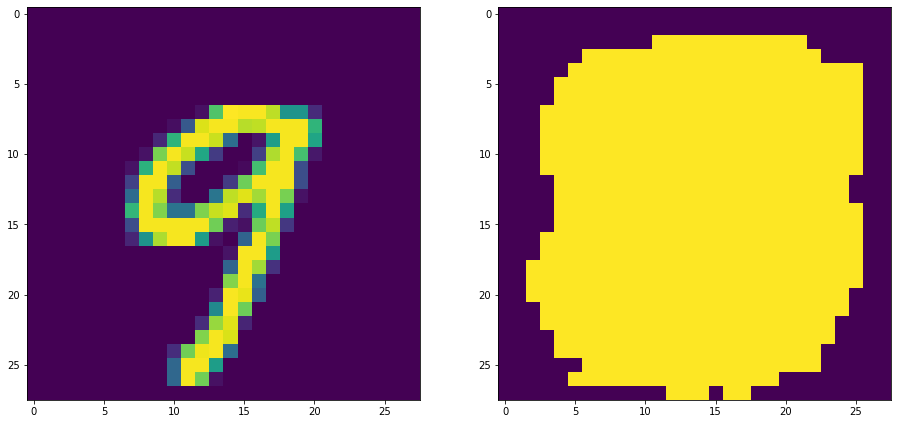

In [12]:
import matplotlib.pyplot as plt
inp_or = train_data[45]
inp = np.reshape(inp_or, [1, np.prod(np.shape(inp_or))])
comp = DBN.dbn_forward(inp)
comp = DBN.dbn_back(np.reshape(comp, [1, 200]))
comp = np.reshape(comp, [28, 28])
plt.subplot(1,2,1)
plt.imshow(inp_or)
plt.subplot(1,2,2)
plt.imshow(comp)
plt.subplots_adjust(left=1, bottom=0, right=3, top=3, wspace=0.2, hspace=0.2)